[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Aplicaciones-Financieras/blob/main/Semana6/Opciones_Américanas_Azucar.ipynb)

# Cargar librerías

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Funciones

#### simula_precios()

La función regresa un dataframe donde cada renglón corresponde a la 
simulación de la trayectoria del precio, bajo la hipótesis de que el precio
del activo sigue un Movimiento Browniano Geométrico, comenzando por el
precio inicial en t = 0,  en la primer columna y t = T en la última.

* precio_inicial: Precio inicial del activo, cuando se firma la opción
* tasa_interes: Tasa de interes considerada para la vigencia de la opción
* sigma: volatilidad (desviación estándar) del precio del activo en un periodo anterior
* T: vigencia en días de la opción 
* trayectorias: número de simulaciones de la trayectoria del precio

In [ ]:
def simula_precios(precio_inicial, tasa_interes, sigma, T, trayectorias):
    # Creamos una matriz de  ceros de tamaño T+1, trayectorias.
    np.random.seed(1)
    MatrizPrecios = np.zeros((trayectorias, T + 1), dtype = np.float64)  
    # Colocamos en el primer renglón(dia0) el precio inicial
    MatrizPrecios[:,0] = precio_inicial  
    
    #Movimiento Brawniano Geométrico para calcular el valor del precio en cada t a partir de t = 1
    for i in range(1, T + 1):
        #partimos de una variable aleatoria distribución normal en cada una de las trayectorias a simular
        Z = np.random.standard_normal(size = trayectorias) 
        weiner_process = sigma * Z / np.sqrt(T)  #weiner_process o movimiento browniano
        MatrizPrecios[:, i] = (MatrizPrecios[:, i - 1] * np.exp((tasa_interes - sigma ** 2 / 2.) * 1 / T + weiner_process ))  # ec. (1.5) Gustafsson (2015)
  
    return pd.DataFrame(MatrizPrecios,  index=['simulacion_'+ str(row) for row in range(1, trayectorias+1)])

#### LSM()

La funcion calcula el valor de una opción. Par ello,  llama a la función  simula_precios para generar las trayectorias de precios del activo, insumo 
para calcular escenarios de ganancias a obtener considerando el precio de 
ejercicio o strike. Finalmente se construye una matriz de valor calculando 
la esperanza condicionada de la ganancia por mantener viva la opción en cada
oportunidad de ejercicio a partir de una regresión polinomial por mínimos cuadrados.

In [ ]:
def LSM(precio_inicial, tasa_interes, sigma, T, trayectorias, precio_strike, tipo ='put'):
    assert tipo == 'call' or tipo == 'put', "el tipo de opción solo puede ser 'call' o 'put'"

    # Paso 1. Creación de Matriz de Precios
    df_precios = simula_precios(precio_inicial, tasa_interes, sigma, T, trayectorias)
    MatrizPrecios = df_precios.values

    # PASO 2. Creación de Matriz de Ganancias
    if tipo == 'call':
       Ganancia = np.maximum(MatrizPrecios - precio_strike,
                             np.zeros((trayectorias, T + 1),dtype=np.float64))
    elif tipo == 'put':
       Ganancia = np.maximum(precio_strike - MatrizPrecios, 
                              np.zeros((trayectorias, T + 1),dtype=np.float64))
    
    # PASO 3. Creación de Matriz de Valor
    MatrizValor = np.zeros_like(Ganancia)
    MatrizValor[:,-1] = Ganancia[:,-1]

    # Regresión polynomial por mínimos cuadrados (orden 2)
    descuento = np.exp(-tasa_interes/T)
    for t in range(T - 1, 0 , -1):
        coeficientes = np.polyfit(MatrizPrecios[:, t],MatrizValor[:, t + 1] * descuento, 2)
        valor_continuar = np.polyval(coeficientes, MatrizPrecios[:, t])
        # Se evaluá si la Ganancia resulta mayor que el valor de continuar
        MatrizValor[:, t] = np.where(Ganancia[:, t] > valor_continuar,
                                     Ganancia[:, t], MatrizValor[:, t + 1] * descuento)
    # PASO 4. El valor de la opción se evalua en el tiempo 0 de la Matriz Valor

    valor_opcion_t0 = MatrizValor[:,1]*descuento
    return  np.mean(valor_opcion_t0)

# Leer y explorar serie de precios

In [ ]:
#importar precios azúcar 2020 obtenidos de Yahoo Finance

precio = pd.read_csv('https://raw.githubusercontent.com/AnIsAsPe/LSM-Opciones-americanas/main/Datos/Precios%20Azucar%202020.csv', # %20 en el nomrbe representa un espacio
                     usecols=['Date', 'Close'], parse_dates=['Date'], index_col = 'Date').dropna()
precio = precio['Close']
precio


# tambien hay disponibles precios de café en:
# 'https://raw.githubusercontent.com/AnIsAsPe/LSM-Opciones-americanas/main/Datos/Precios%20Cafe%202020.csv'

In [ ]:
precio

Date
2020-01-02    13.13
2020-01-03    13.31
2020-01-06    13.73
2020-01-07    13.59
2020-01-08    13.47
              ...  
2020-12-22    14.54
2020-12-23    14.83
2020-12-28    14.98
2020-12-29    15.04
2020-12-30    15.28
Name: Close, Length: 250, dtype: float64

# Paso a Paso funcion LSM

In [ ]:
precio_inicial = precio[-1]
tasa_interes = 0.06
sigma = np.std(precio)
T = 250 
trayectorias = 150000
precio_strike = 14 
tipo ='put'

In [ ]:
LSM(precio_inicial, tasa_interes, sigma, T, trayectorias, precio_strike, tipo)

In [ ]:
    # Paso 1. Creación de Matriz de Precios
df_precios = simula_precios(precio_inicial, tasa_interes, sigma, T, trayectorias)
MatrizPrecios = df_precios.values
MatrizPrecios

array([[15.28      , 18.06097666, 16.40643221, ..., 38.80410353,
        39.47568374, 38.24570042],
       [15.28      , 14.24104824, 15.52556513, ..., 14.07218649,
        12.8028059 , 11.79958525],
       [15.28      , 14.36810551, 16.11327142, ..., 24.69009506,
        25.06967267, 26.87579521],
       ...,
       [15.28      , 13.66897418, 13.97513593, ...,  0.29829446,
         0.38907544,  0.45603525],
       [15.28      , 13.72721164, 14.28721107, ...,  0.54078721,
         0.48922841,  0.40411323],
       [15.28      , 14.38803617, 14.34535309, ...,  1.71426216,
         2.00155068,  1.80495257]])

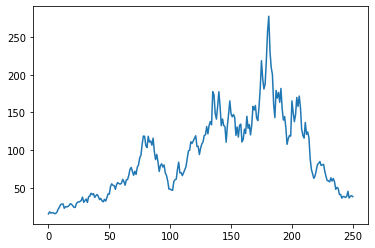

In [ ]:
# Plot de opción específica. para análisis de caso extraño
pd.Series(MatrizPrecios[0,:]).plot()

In [ ]:
    # PASO 2. Creación de Matriz de Ganancias
Ganancia = np.maximum(MatrizPrecios - precio_strike,
                          np.zeros((trayectorias, T + 1),dtype=np.float64))
Ganancia

array([[ 1.28      ,  4.06097666,  2.40643221, ..., 24.80410353,
        25.47568374, 24.24570042],
       [ 1.28      ,  0.24104824,  1.52556513, ...,  0.07218649,
         0.        ,  0.        ],
       [ 1.28      ,  0.36810551,  2.11327142, ..., 10.69009506,
        11.06967267, 12.87579521],
       ...,
       [ 1.28      ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.28      ,  0.        ,  0.28721107, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.28      ,  0.38803617,  0.34535309, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
        # PASO 3. Creación de Matriz de Valor
MatrizValor = np.zeros_like(Ganancia)
MatrizValor[:,-1] = Ganancia[:,-1]

In [ ]:
MatrizValor

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 24.24570042],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 12.87579521],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
descuento = np.exp(-tasa_interes/T)
descuento

0.9997600287976961

In [ ]:
for t in range(T - 1, 0 , -1):
    coeficientes = np.polyfit(MatrizPrecios[:, t],MatrizValor[:, t + 1] * descuento, 2)
    valor_continuar = np.polyval(coeficientes, MatrizPrecios[:, t])
        # Se evaluá si la Ganancia resulta mayor que el valor de continuar
    MatrizValor[:, t] = np.where(Ganancia[:, t] > valor_continuar,
                                     Ganancia[:, t], MatrizValor[:, t + 1] * descuento)
    # PASO 4. El valor de la opción se evalua en el tiempo 0 de la Matriz Valor

valor_opcion_t0 = MatrizValor[:,1]*descuento

In [ ]:
valor_opcion_t0

array([37.25118279,  0.        , 12.12596727, ...,  0.        ,
        0.        , 19.81468871])

# Ver serie de datos

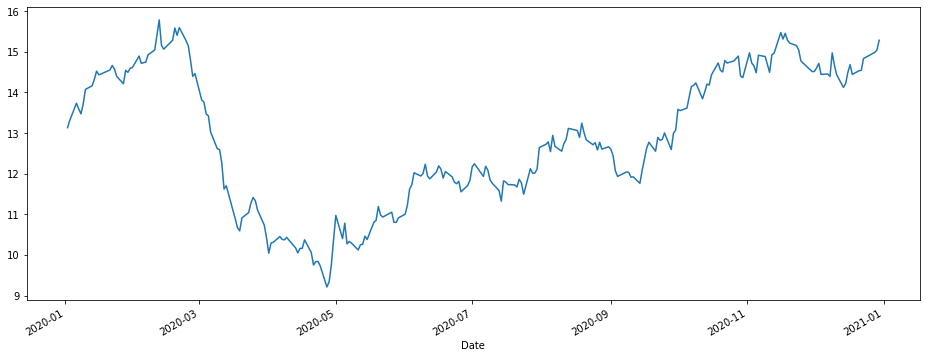

In [ ]:
#visualizar serie
precio.plot(figsize=(16,6))
plt.show()

#Simulación Monte Carlo trayectorias de precio a un año
tasa de interés 6%

In [ ]:
precio_ini = precio[-1]
sigma = np.std(precio)

precio_ini, sigma

(15.28, 1.6802378669700317)

In [ ]:
#considerando la misma cantidad de días que en 2020 hacemos la simulación Montecarlo de un proceso Browniano
tasa = 0.06
dias = 250
n = 150000


Precios_df = simula_precios(precio_ini, tasa, sigma , dias, n  )
Precios_df

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
simulacion_1,15.28,18.060977,16.406432,16.838242,16.924636,15.518943,16.016037,17.669512,21.423348,24.204305,...,36.259308,38.482675,38.178442,37.205864,38.444260,45.266676,36.448669,38.804104,39.475684,38.245700
simulacion_2,15.28,14.241048,15.525565,13.855051,12.948856,13.811845,15.031347,14.954741,12.414231,12.061508,...,12.446060,10.850052,13.451582,13.233271,14.634498,13.164291,15.062333,14.072186,12.802806,11.799585
simulacion_3,15.28,14.368106,16.113271,15.540289,13.512858,13.264096,13.793355,12.755201,13.236939,12.683623,...,18.441248,21.819707,21.363898,21.602720,25.223740,23.984206,21.223977,24.690095,25.069673,26.875795
simulacion_4,15.28,13.559896,12.339173,13.377374,12.948717,14.637623,16.254156,16.026738,16.387275,16.115447,...,0.115282,0.116890,0.117557,0.111731,0.112572,0.112189,0.125289,0.099347,0.114480,0.106068
simulacion_5,15.28,16.661541,15.717514,18.234894,14.945779,14.753333,13.651108,12.524000,14.179887,16.121673,...,0.990517,1.077194,1.077951,0.905259,0.873507,0.889269,0.802048,0.802266,0.826012,0.774835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
simulacion_149996,15.28,13.837594,11.534960,10.943446,11.752134,11.125993,10.909013,10.669336,10.084214,14.578779,...,9.634623,10.136444,10.187417,9.848161,7.653463,6.668219,6.222238,5.497907,5.929493,5.198978
simulacion_149997,15.28,15.649129,14.794699,14.325862,13.314188,13.911507,13.455040,13.382879,14.255800,10.978444,...,0.904840,0.835897,0.784132,0.777573,0.656785,0.677645,0.576941,0.591222,0.595141,0.660580
simulacion_149998,15.28,13.668974,13.975136,13.306954,14.909825,15.441510,15.180498,14.123501,13.427514,13.033498,...,0.232368,0.231464,0.223044,0.211233,0.283735,0.303129,0.285386,0.298294,0.389075,0.456035
simulacion_149999,15.28,13.727212,14.287211,17.518563,17.232442,17.202864,17.083130,17.029021,16.984777,16.325477,...,0.618167,0.506468,0.526723,0.492737,0.546912,0.533252,0.477810,0.540787,0.489228,0.404113


In [ ]:
Precios_df.T

,simulacion_1,simulacion_2,simulacion_3,simulacion_4,simulacion_5,simulacion_6,simulacion_7,simulacion_8,simulacion_9,simulacion_10,...,simulacion_149991,simulacion_149992,simulacion_149993,simulacion_149994,simulacion_149995,simulacion_149996,simulacion_149997,simulacion_149998,simulacion_149999,simulacion_150000
0,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,...,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000
1,18.060977,14.241048,14.368106,13.559896,16.661541,11.900251,18.293674,14.016662,15.721700,14.800166,...,12.721135,19.096850,14.825613,12.960851,16.300836,13.837594,15.649129,13.668974,13.727212,14.388036
2,16.406432,15.525565,16.113271,12.339173,15.717514,10.357286,17.824686,10.793508,15.070186,15.073589,...,13.791070,18.136799,14.882074,13.078345,19.618958,11.534960,14.794699,13.975136,14.287211,14.345353
3,16.838242,13.855051,15.540289,13.377374,18.234894,10.830479,19.338661,9.235002,18.788153,15.047159,...,15.433095,17.074688,12.423568,14.774022,18.007154,10.943446,14.325862,13.306954,17.518563,15.291400
4,16.924636,12.948856,13.512858,12.948717,14.945779,10.835134,20.672543,9.704801,20.642344,13.324474,...,14.383024,21.363447,11.872114,15.051561,21.027133,11.752134,13.314188,14.909825,17.232442,17.929918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,45.266676,13.164291,23.984206,0.112189,0.889269,2.393416,6.406579,0.684703,2.191201,0.247344,...,5.839130,1.042259,26.189942,1.247789,3.173335,6.668219,0.677645,0.303129,0.533252,1.897264
247,36.448669,15.062333,21.223977,0.125289,0.802048,2.330450,8.417359,0.677949,1.970630,0.246323,...,5.547074,1.025021,27.196153,1.053691,2.957058,6.222238,0.576941,0.285386,0.477810,1.893230
248,38.804104,14.072186,24.690095,0.099347,0.802266,2.440712,8.124840,0.689697,1.777611,0.216151,...,5.923994,1.011694,24.211752,1.027130,2.727001,5.497907,0.591222,0.298294,0.540787,1.714262
249,39.475684,12.802806,25.069673,0.114480,0.826012,1.946525,10.029688,0.765988,2.064585,0.177800,...,5.711847,0.987935,20.993648,1.051231,2.774387,5.929493,0.595141,0.389075,0.489228,2.001551


['simulacion_149795' 'simulacion_62813' 'simulacion_127245'
 'simulacion_25619' 'simulacion_71471' 'simulacion_54236'
 'simulacion_64266' 'simulacion_88824' 'simulacion_6325' 'simulacion_268']


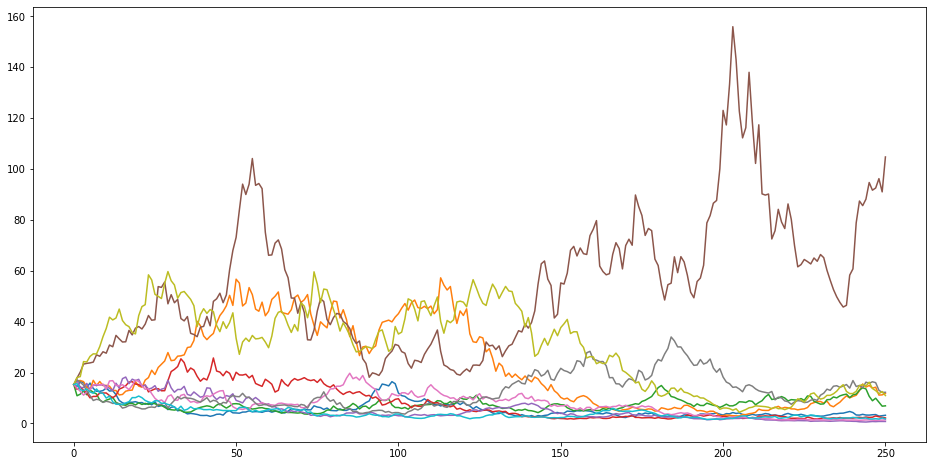

In [ ]:
muestra = np.random.choice(Precios_df.index, 10)
print(muestra)
Precios_df.transpose()[muestra].plot(figsize=(16, 8), legend=False)
plt.show()

# Construcción de la Matriz de Ganancias

In [ ]:
# Calcular Matriz de ganancias para opciones "put" 
# 0 si el precio es mayor o igual al strike
Strike = 14
Ganancia = np.maximum(Strike - Precios_df.values, np.zeros((n, dias + 1),dtype=np.float64))
pd.DataFrame(Ganancia, index = Precios_df.index).iloc[:, -5:]

,246,247,248,249,250
simulacion_1,0.000000,0.000000,0.000000,0.000000,0.000000
simulacion_2,0.835709,0.000000,0.000000,1.197194,2.200415
simulacion_3,0.000000,0.000000,0.000000,0.000000,0.000000
simulacion_4,13.887811,13.874711,13.900653,13.885520,13.893932
simulacion_5,13.110731,13.197952,13.197734,13.173988,13.225165
...,...,...,...,...,...
simulacion_149996,7.331781,7.777762,8.502093,8.070507,8.801022
simulacion_149997,13.322355,13.423059,13.408778,13.404859,13.339420
simulacion_149998,13.696871,13.714614,13.701706,13.610925,13.543965
simulacion_149999,13.466748,13.522190,13.459213,13.510772,13.595887


# Construcción de la Matriz de Valor 

In [ ]:
MatrizValor = np.zeros_like(Ganancia)
MatrizValor[:, -1] = Ganancia[:, -1]  #empezamos en el ultimo día
descuento = np.exp(-tasa/dias)

#Regresión polynomial por mínimos cuadrados para calcular el valor de continuar
for t in range(dias-1, 0 , -1): #desde el penúltimo día
    x = Precios_df.iloc[:,t]
    y = MatrizValor[:, t + 1] * descuento
    #encuentra los coeficientes 
    coeficientes = np.polyfit(x, y , 2)
    valor_continuar = np.polyval(coeficientes, x)
    #Cuando la ganancia en el tiempo t sea mayor que el valor de continuar,
    MatrizValor[:, t] = np.where(Ganancia[:, t] > valor_continuar,
                                  Ganancia[:, t],
                                  MatrizValor[:, t + 1] * descuento)

pd.DataFrame(MatrizValor, index = Precios_df.index)#.iloc[:, -5:]

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
simulacion_1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
simulacion_2,0.0,9.422175,9.424436,9.426698,9.428961,9.431224,9.433488,9.435752,9.438017,9.440283,...,2.195667,2.196194,2.196721,2.197248,2.197776,2.198303,2.198831,2.199359,2.199887,2.200415
simulacion_3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
simulacion_4,0.0,8.930513,8.932657,8.934801,8.936946,8.939091,8.941237,8.943383,8.945529,8.947677,...,13.884718,13.883110,13.882443,13.888269,13.887428,13.887811,13.874711,13.900653,13.885520,13.893932
simulacion_5,0.0,9.536020,9.538309,9.540599,9.542889,9.545179,9.547471,9.549762,9.552054,9.554347,...,13.009483,12.922806,12.922049,13.094741,13.126493,13.110731,13.197952,13.197734,13.173988,13.225165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
simulacion_149996,0.0,9.148369,9.150565,9.152761,9.154958,9.157156,9.159354,9.161552,9.163751,9.165951,...,8.487822,8.489859,8.491897,8.493935,8.495974,8.498013,8.500053,8.502093,8.798910,8.801022
simulacion_149997,0.0,9.078723,9.080903,9.083082,9.085262,9.087443,9.089624,9.091806,9.093989,9.096171,...,13.095160,13.164103,13.215868,13.222427,13.343215,13.322355,13.423059,13.408778,13.404859,13.339420
simulacion_149998,0.0,9.059094,9.061268,9.063443,9.065619,9.067795,9.069971,9.072148,9.074326,9.076504,...,13.767632,13.768536,13.776956,13.788767,13.716265,13.696871,13.714614,13.701706,13.610925,13.543965
simulacion_149999,0.0,9.389396,9.391649,9.393904,9.396158,9.398414,9.400670,9.402926,9.405183,9.407441,...,13.381833,13.493532,13.473277,13.507263,13.453088,13.466748,13.522190,13.459213,13.510772,13.595887


In [ ]:
valor_opcion_t0 = np.mean(MatrizValor[:,1]*descuento)
valor_opcion_t0

6.895748135085395

# Todo junto

In [ ]:
precio_ini, Strike, sigma, tasa, dias, n

(15.28, 14, 1.6802378669700317, 0.06, 250, 150000)

In [ ]:
Strike = 16

In [ ]:
LSM(precio_ini, tasa, sigma, dias, n,  Strike, 'put')  # el comprador de la opción tiene derecho
                                                   # vender al precio Strike
                                                   # el vendedor de la opción tiene la 
                                                   # obligacion de comprar al precio del Strike

8.418835923492331

In [ ]:
# Strike = 17, opcion = 9.202843206135679
# Strike = 16, opcion = 8.418835923492331
# Strike = 14, opcion = 6.895748135085395

In [ ]:
LSM(precio_ini, tasa, sigma, dias, n, Strike, 'call')  # el comprador de la opción tiene derecho
                                                   # comprar al precio Strike
                                                   # el vendedor de la opción tiene la 
                                                   # obligacion de vender al precio del Strike

7.5495619977475705

In [ ]:
# Strike = 17, opcion = 7.358241093468457
# Strike = 16, opcion = 7.5495619977475705
# Strike = 14, opcion = 7.946914889428674

# Referencias

1. Longstaff FA, Schwartz ES. Valuing American Options by Simulation: A Simple Least-Squares Approach. Rev Financ Stud [Internet]. enero de 2001 [citado 22 de abril de 2021];14(1):113-47. Disponible en: https://academic.oup.com/rfs/article-lookup/doi/10.1093/rfs/14.1.113

2. Gustafsson W. Evaluating the Longstaff-Schwartz method for pricing of American options [Internet]. undefined. 2015 [citado 8 de febrero de 2021]. Disponible en: /paper/Evaluating-the-Longstaff-Schwartz-method-for-of-Gustafsson/d1e22230c3852f60bef3b32f4230fefc88a18768

3. tirthajyoti/Stats-Maths-with-Python [Internet]. GitHub. [citado 9 de febrero de 2021]. Disponible en: https://github.com/tirthajyoti/Stats-Maths-with-Python

